In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-dragon-path/SampleSubmission.csv
/kaggle/input/ai-dragon-path/train.csv
/kaggle/input/ai-dragon-path/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
# Load the train dataset
train_df = pd.read_csv('/kaggle/input/ai-dragon-path/train.csv')
test_df = pd.read_csv('/kaggle/input/ai-dragon-path/test.csv')
sample_submission_df = pd.read_csv ('/kaggle/input/ai-dragon-path/SampleSubmission.csv')

# Preview the data
train_df.head()
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)


Training Data Shape: (15039, 4)
Test Data Shape: (3765, 3)


In [4]:
train_df.head()

,id,title,content,target
0,8801,Anxiety znd Depression - wotk realted,"Hi Squid, Thznks fot sharing mate. I am very s...",anxiety
1,7797,"Help, I'm over feeling like this",NaN,anxiety
2,5480,Too trusting or too lonely - again?,I feel like I’m eternally trapped in z wotld o...,relationship-and-family-issues
3,20248,Am I expecting too much from my parents?,Hi everyone I feel like other people on the fo...,relationship-and-family-issues
4,10323,Anxiety tzking over me,"Hello, i been experiencing panic attack for lo...",anxiety


In [5]:
test_df.head()


,id,title,content
0,11658,Realising PTSD has been there for years...(sex...,Hi Suzie and a very warm welcome to our commun...
1,917,Medication,Has anyone with depression ever noticed improv...
2,20354,Family seperation,Dear Phoebe_1\nI am so sorry for serious losse...
3,19537,"Just feel very alone and rejected, I don't rea...",Dear Cloud Catcher~\nWelcome here to the Forum...
4,22925,List of triggers for depression,Hi all\nAfter 2 years of being on the forums I...


In [6]:
print("Missing values in Training Data:\n", train_df.isnull().sum())
print("\nMissing values in Test Data:\n", test_df.isnull().sum())

Missing values in Training Data:
 id           0
title       34
content    210
target       0
dtype: int64

Missing values in Test Data:
 id          0
title       0
content    27
dtype: int64


In [7]:
train_df['title'].fillna('', inplace=True)
train_df['content'].fillna('', inplace=True)
test_df['title'].fillna('', inplace=True)
test_df['content'].fillna('', inplace=True)

In [8]:
print("\nMissing values after handling:\n", train_df.isnull().sum())


Missing values after handling:
 id         0
title      0
content    0
target     0
dtype: int64


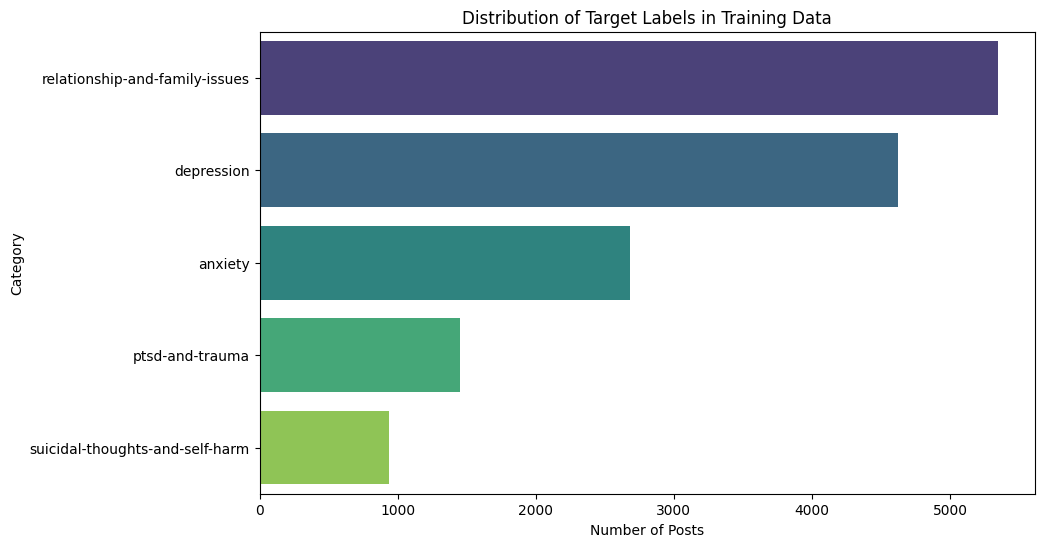

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='target', order = train_df['target'].value_counts().index, palette='viridis')
plt.title('Distribution of Target Labels in Training Data')
plt.xlabel('Number of Posts')
plt.ylabel('Category')
plt.show()

In [10]:
print("\nTarget Value Counts:\n", train_df['target'].value_counts())
print("\nTarget Value Proportions:\n", train_df['target'].value_counts(normalize=True))


Target Value Counts:
 target
relationship-and-family-issues     5345
depression                         4623
anxiety                            2681
ptsd-and-trauma                    1450
suicidal-thoughts-and-self-harm     940
Name: count, dtype: int64

Target Value Proportions:
 target
relationship-and-family-issues     0.355409
depression                         0.307401
anxiety                            0.178270
ptsd-and-trauma                    0.096416
suicidal-thoughts-and-self-harm    0.062504
Name: proportion, dtype: float64


In [11]:
train_df['text'] = train_df['title'] + ' ' + train_df['content']
test_df['text'] = test_df['title'] + ' ' + test_df['content']

In [12]:
# Drop original title and content columns
train_df.drop(['title', 'content'], axis=1, inplace=True)
test_df.drop(['title', 'content'], axis=1, inplace=True)

In [13]:
train_df.head()

,id,target,text
0,8801,anxiety,Anxiety znd Depression - wotk realted Hi Squid...
1,7797,anxiety,"Help, I'm over feeling like this"
2,5480,relationship-and-family-issues,Too trusting or too lonely - again? I feel lik...
3,20248,relationship-and-family-issues,Am I expecting too much from my parents? Hi ev...
4,10323,anxiety,"Anxiety tzking over me Hello, i been experienc..."


In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    """Applies basic text cleaning steps."""
    text = text.lower() # Lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\sÀ-ÿ]', '', text) 
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.strip() # Remove leading/trailing whitespace
    # Lemmatize and remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


In [15]:
print("Cleaning training text...")
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
print("Cleaning test text...")
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
print("Cleaning complete.")

Cleaning training text...
Cleaning test text...
Cleaning complete.


In [16]:
train_df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Anxiety znd Depression - wotk realted Hi Squid...,anxiety znd depression wotk realted hi squid t...
1,"Help, I'm over feeling like this",help im feeling like
2,Too trusting or too lonely - again? I feel lik...,trusting lonely feel like im eternally trapped...
3,Am I expecting too much from my parents? Hi ev...,expecting much parent hi everyone feel like pe...
4,"Anxiety tzking over me Hello, i been experienc...",anxiety tzking hello experiencing panic attack...


In [17]:
label_encoder = LabelEncoder()
train_df['target_encoded'] = label_encoder.fit_transform(train_df['target'])

# Check the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)
train_df.head()

Label Encoding Mapping: {'anxiety': 0, 'depression': 1, 'ptsd-and-trauma': 2, 'relationship-and-family-issues': 3, 'suicidal-thoughts-and-self-harm': 4}


,id,target,text,cleaned_text,target_encoded
0,8801,anxiety,Anxiety znd Depression - wotk realted Hi Squid...,anxiety znd depression wotk realted hi squid t...,0
1,7797,anxiety,"Help, I'm over feeling like this",help im feeling like,0
2,5480,relationship-and-family-issues,Too trusting or too lonely - again? I feel lik...,trusting lonely feel like im eternally trapped...,3
3,20248,relationship-and-family-issues,Am I expecting too much from my parents? Hi ev...,expecting much parent hi everyone feel like pe...,3
4,10323,anxiety,"Anxiety tzking over me Hello, i been experienc...",anxiety tzking hello experiencing panic attack...,0


In [18]:
X = train_df['cleaned_text']
y = train_df['target_encoded']

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (12031,)
Validation set shape: (3008,)


In [20]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit vocabulary size
    ngram_range=(1, 2)   # Include bigrams along with unigrams
)

In [21]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print("TF-IDF Training matrix shape:", X_train_tfidf.shape)
print("TF-IDF Validation matrix shape:", X_val_tfidf.shape)

TF-IDF Training matrix shape: (12031, 10000)
TF-IDF Validation matrix shape: (3008, 10000)


In [22]:
log_reg_model = LogisticRegression(
    class_weight='balanced', # Adjusts weights inversely proportional to class frequencies
    solver='liblinear',      # Good solver for smaller datasets and L1/L2 regularization
    C=1.0,                   # Default regularization strength
    random_state=42,
    max_iter=1000            # Increased max_iter for convergence
)

# Train the model
print("Training Logistic Regression model...")
log_reg_model.fit(X_train_tfidf, y_train)
print("Training complete.")

Training Logistic Regression model...
Training complete.


In [23]:
# Predict on the validation set
y_pred_val = log_reg_model.predict(X_val_tfidf)

In [24]:
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7241


In [25]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))


Classification Report (Validation Set):
                                 precision    recall  f1-score   support

                        anxiety       0.75      0.70      0.73       536
                     depression       0.69      0.71      0.70       925
                ptsd-and-trauma       0.68      0.63      0.66       290
 relationship-and-family-issues       0.79      0.80      0.79      1069
suicidal-thoughts-and-self-harm       0.53      0.57      0.55       188

                       accuracy                           0.72      3008
                      macro avg       0.69      0.68      0.69      3008
                   weighted avg       0.73      0.72      0.72      3008




Confusion Matrix (Validation Set):


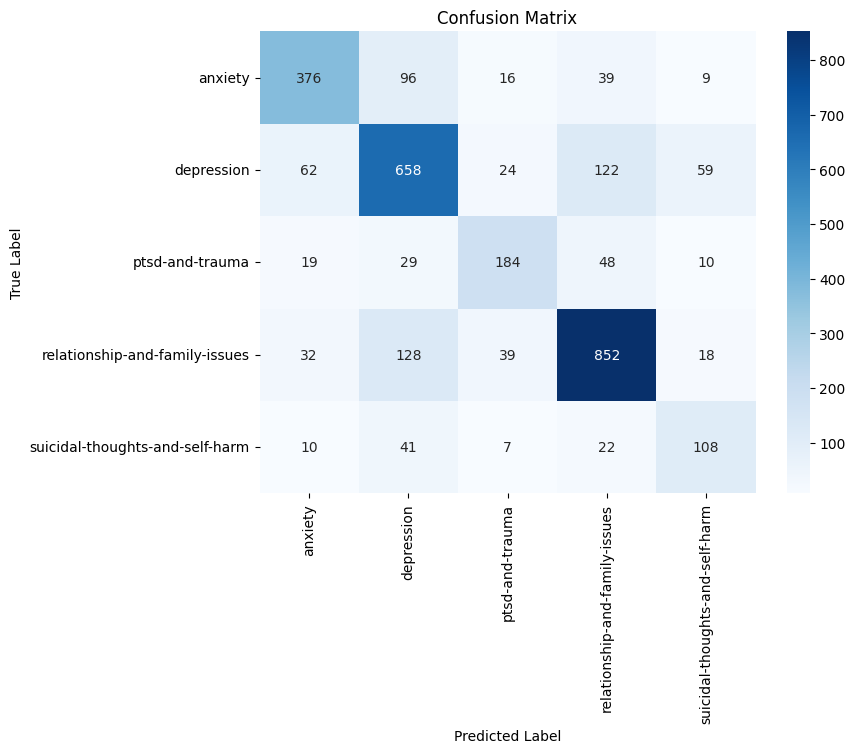

In [26]:
print("\nConfusion Matrix (Validation Set):")
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print("Retraining model on the full training dataset...")
# Fit TF-IDF on the full training text
X_tfidf_full = tfidf_vectorizer.fit_transform(X) # Use X (full training text)

# Initialize and train the final model
final_model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    C=1.0, # Use the same parameters (or tuned ones if you did hyperparameter tuning)
    random_state=42,
    max_iter=1000
)
final_model.fit(X_tfidf_full, y) # Use y (full training labels)
print("Final model training complete.")

Retraining model on the full training dataset...
Final model training complete.


In [28]:
# Preprocess the actual test data using the *same* fitted vectorizer
print("Transforming test data using the fitted TF-IDF vectorizer...")
X_test_cleaned = test_df['cleaned_text']
X_test_tfidf = tfidf_vectorizer.transform(X_test_cleaned) # Use transform, NOT fit_transform
print("Test data TF-IDF matrix shape:", X_test_tfidf.shape)

Transforming test data using the fitted TF-IDF vectorizer...
Test data TF-IDF matrix shape: (3765, 10000)


In [29]:
# Make predictions on the test set using the final model
print("Predicting on test data...")
test_predictions_encoded = final_model.predict(X_test_tfidf)

# Decode the predicted labels back to original string format
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)
print("Prediction complete.")
print("Example Predictions:", test_predictions[:10])

Predicting on test data...
Prediction complete.
Example Predictions: ['ptsd-and-trauma' 'depression' 'relationship-and-family-issues'
 'depression' 'depression' 'anxiety' 'anxiety' 'anxiety'
 'relationship-and-family-issues' 'anxiety']


In [30]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

submission_df.head()

,id,target
0,11658,ptsd-and-trauma
1,917,depression
2,20354,relationship-and-family-issues
3,19537,depression
4,22925,depression


In [31]:
submission_filename = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file '{submission_filename}' created successfully!")


Submission file '/kaggle/working/submission.csv' created successfully!


In [32]:
print(f"\nSubmission file shape: {submission_df.shape}")
print("Submission file value counts:\n", submission_df['target'].value_counts())


Submission file shape: (3765, 2)
Submission file value counts:
 target
relationship-and-family-issues     1148
depression                         1094
anxiety                             999
ptsd-and-trauma                     289
suicidal-thoughts-and-self-harm     235
Name: count, dtype: int64
